# Quantum Phase Estimation (QPE) for H₂ — **Noisy**

- Uses PennyLane and project utilities
- Adds simple depolarizing noise model
- Compares to Hartree–Fock (HF)
- Includes sweeps over noise strengths

In [1]:
import numpy as np

from qpe.core import run_qpe
from qpe.hamiltonian import build_hamiltonian
from qpe.io_utils import ensure_dirs, load_qpe_result, save_qpe_result
from qpe.visualize import plot_qpe_distribution, plot_qpe_sweep

ensure_dirs()


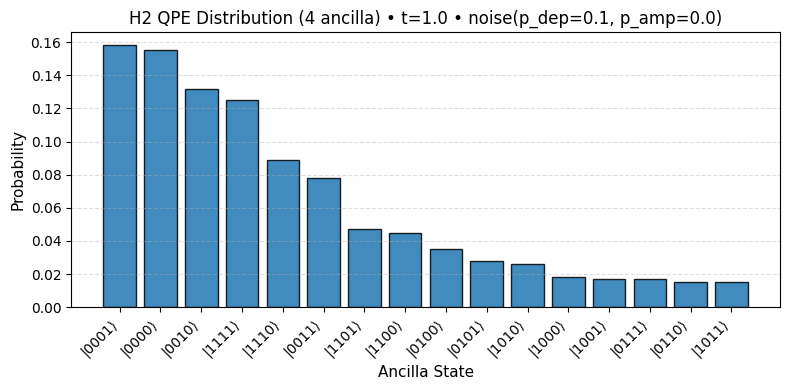

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qpe/H2/distribution_dep10_4ancilla_t1.png


In [2]:
molecule_name = "H2"
seed = 0

H, n_qubits, hf_state, symbols, coordinates, basis, charge = build_hamiltonian(molecule_name)

n_ancilla = 4
t_evol = 1.0
trotter_steps = 2
shots = 1000
noise_params = {"p_dep": 0.1, "p_amp": 0.0}

result = load_qpe_result(
    molecule=molecule_name,
    n_ancilla=int(n_ancilla),
    t=float(t_evol),
    seed=int(seed),
    shots=int(shots) if shots is not None else None,
    noise=noise_params,
    trotter_steps=int(trotter_steps),
)

if result is None:
    result = run_qpe(
        hamiltonian=H,
        hf_state=hf_state,
        n_ancilla=int(n_ancilla),
        t=float(t_evol),
        trotter_steps=int(trotter_steps),
        noise_params=noise_params,
        shots=int(shots) if shots is not None else None,
        molecule_name=molecule_name,
    )
    result["system_qubits"] = int(n_qubits)
    result["seed"] = int(seed)
    result["noise"] = dict(noise_params)
    save_qpe_result(result)

plot_qpe_distribution(result, show=True, save=True)


In [3]:
# Sweep over depolarizing probability (multi-seed)
p_dep_list = np.linspace(0.0, 0.1, 11)
seeds = list(range(5))

means, stds = [], []
peaks_mean, peaks_std = [], []

for p in p_dep_list:
    Es, Ps = [], []
    for seed in seeds:
        nparams = {"p_dep": float(p), "p_amp": 0.0}

        r = load_qpe_result(
            molecule=molecule_name,
            n_ancilla=int(n_ancilla),
            t=float(t_evol),
            seed=int(seed),
            shots=int(shots) if shots is not None else None,
            noise=nparams,
            trotter_steps=int(trotter_steps),
        )

        if r is None:
            r = run_qpe(
                hamiltonian=H,
                hf_state=hf_state,
                n_ancilla=int(n_ancilla),
                t=float(t_evol),
                trotter_steps=int(trotter_steps),
                noise_params=nparams,
                shots=int(shots) if shots is not None else None,
                molecule_name=molecule_name,
            )
            r["system_qubits"] = int(n_qubits)
            r["seed"] = int(seed)
            r["noise"] = dict(nparams)
            save_qpe_result(r)

        Es.append(float(r["energy"]))
        Ps.append(float(r["probs"][r["best_bitstring"]]))

    Es = np.asarray(Es, dtype=float)
    Ps = np.asarray(Ps, dtype=float)

    means.append(float(Es.mean()))
    stds.append(float(Es.std(ddof=1)) if len(Es) > 1 else 0.0)

    peaks_mean.append(float(Ps.mean()))
    peaks_std.append(float(Ps.std(ddof=1)) if len(Ps) > 1 else 0.0)


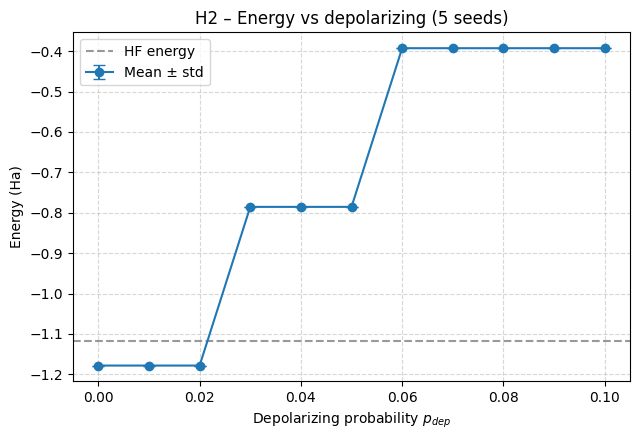

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qpe/H2/sweep_4ancilla_energy_vs_depolarizing_5_seeds.png


In [4]:
plot_qpe_sweep(
    p_dep_list,
    means,
    stds,
    molecule=molecule_name,
    sweep_label="Depolarizing probability $p_{dep}$",
    ylabel="Energy (Ha)",
    title=f"Energy vs depolarizing ({len(seeds)} seeds)",
    ref_value=result["hf_energy"],
    ref_label="HF energy",
    ancilla=n_ancilla,
    noise_params={"p_dep": 0.0, "p_amp": 0.0},
    show=True,
    save=True,
)


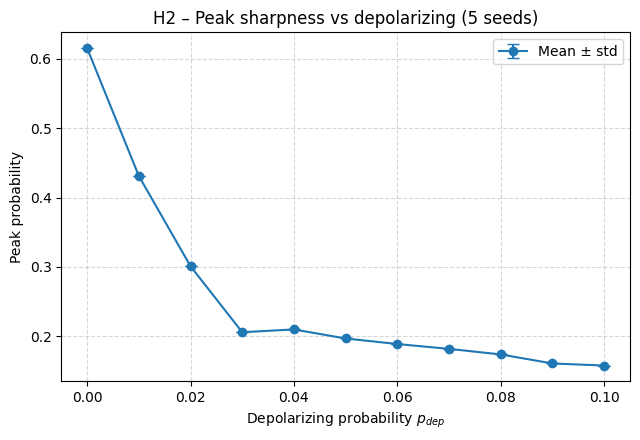

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qpe/H2/sweep_4ancilla_peak_sharpness_vs_depolarizing_5_seeds.png


In [6]:
plot_qpe_sweep(
    p_dep_list,
    peaks_mean,
    peaks_std,
    molecule=molecule_name,
    sweep_label="Depolarizing probability $p_{dep}$",
    ylabel="Peak probability",
    title=f"Peak sharpness vs depolarizing ({len(seeds)} seeds)",
    ref_value=None,
    ancilla=n_ancilla,
    noise_params={"p_dep": 0.0, "p_amp": 0.0},
    show=True,
    save=True,
)
